# Assignment on Amazon Fine Food Reviews Analysis

In [1]:
# importing library

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
nltk.download('stopwords')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
# to connect the database 

con=sqlite3.connect('database.sqlite')
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
#creating new datasets after applying filter on reviews dataset

filtered_data=pd.read_sql_query("""SELECT * from Reviews where score!= 3""", con)
#  with the help of method whose value less than 3, it is Negative otherwise positive

def partition(x):
    if x<3:
        return 'negative'
    return 'positive'
#changing reviews with score less than 3 to be positive and vice-versa
# with the help of this method returning positive and negative based on the score
# storing in new data set 

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DVS0283\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


C:\Users\DVS0283\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
print(filtered_data.shape)#looking at the size of the data

(525814, 10)


# Exploratory Data Analysis
## Data Cleaning : Deduplication

In [3]:
# DISPLAY DATA ORDER BY PRODUCT ID

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head() # REPRESENTATION OF TOP 5 REVIEWS

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [4]:
# Sorting the data according to the productid 
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
# Deleting duplicate data where some of the features are same
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
# PERCENTAGE OF DATA REMAINING AFTER FILTERING THE DATA 
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [7]:
# we are not considering those values which score equal to 3
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head() # representation of data of top 5 reviews

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
# HelpfulnessNumerator - number of users who found the review helpful
#HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
# As we know that helfulnessnumerator will not  be greater than helpfullness denominator 
# So we will remove that reviews because that reviews no make sense 

final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
# shape of final data
# after removing reviews in above cell which were useless, no make sense
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

# TEXT PREPROCESSING
Stemming, stop-word removal and Lemmatization

In [10]:
# removing html tags punctuations and special characters 
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence):  #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop) # all the stop words after removing html tags,punctuation or special characters
# just for understandng the stop words  

{'our', 'above', 'most', 'has', 've', "aren't", 'why', 'she', 'ourselves', "you've", 'will', 'yours', 'myself', "wouldn't", 'theirs', 'further', "hasn't", "isn't", 'after', 'their', 'his', "that'll", 'having', 'did', 'under', "should've", 'd', 'ours', 'here', "you'd", 'other', 's', 'he', 'any', 'aren', 'nor', 'then', 'shouldn', 'doing', 'what', 'does', 'didn', 'with', 'my', "you're", 'yourselves', 'not', 'wasn', 'than', 'had', 'from', 'hers', 'over', "shan't", 'in', 'an', "couldn't", 'where', 'down', 'do', 'more', 'now', 'against', 'himself', 'some', 'these', 'be', 'when', 'mightn', 'doesn', 'on', "hadn't", 'hadn', 'just', 'because', 'through', 'don', 'so', 'all', 'it', 'we', 'again', 'couldn', 'at', "you'll", "weren't", 'were', 'your', 'are', 'him', 'both', 'to', 'each', "it's", 'isn', 'those', 'you', 'hasn', "don't", 'own', "she's", 'itself', 'the', 'me', 'that', 'about', 'll', 'during', 'whom', 'themselves', 're', "wasn't", 'between', 'as', 'such', 'no', 'should', 'is', 'off', 'if',

In [11]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)): # assure that cleaned words are alphabetical and length is greater than 2
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) 
        
    final_string.append(str1) #final string of cleaned words
    i+=1

In [12]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [13]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite') 
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

# Bag of Words (BoW)

In [14]:
#BoW
final=final.head(4000) # we are taking samples of dataset
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['CleanedText'].values) #fitting th model of dataset which is given.
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4000, 9492)
the number of unique words  9492


In [15]:
#changinrix to dense matixg sparse mat
final_counts=final_counts.toarray()

In [16]:
#importing library for standarized the data to apply tsne
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()


In [17]:
# standarizing the data to apply tsne
standarized_data=sc.fit_transform(final_counts)
import warnings
warnings.filterwarnings("ignore")

C:\Users\DVS0283\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\DVS0283\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# tsne on bag of words

In [18]:
from sklearn.manifold import TSNE #importing library for tsne

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(standarized_data) #created data to plot tsne 


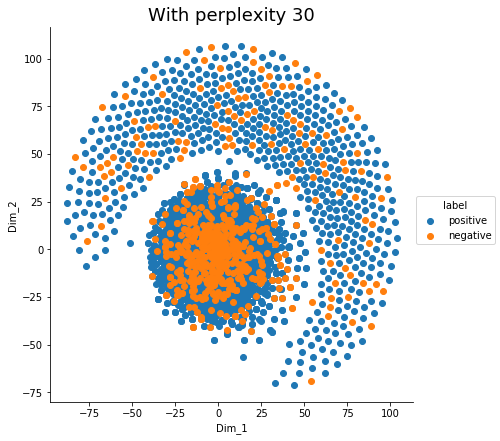

In [19]:
import seaborn as sn


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("With perplexity 30",size=18)
plt.show()


# With perplexity 50

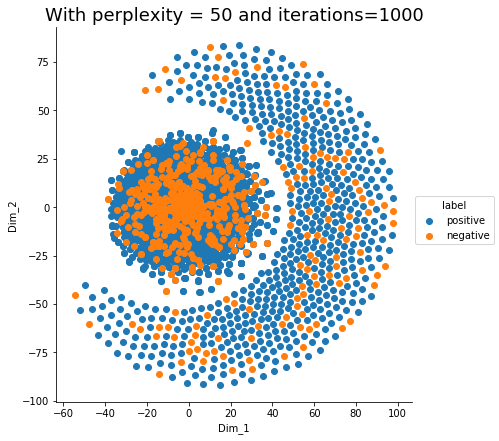

In [20]:
model = TSNE(n_components=2, random_state=0,perplexity=50)
# configuring the parameteres
# the number of components = 2
# default perplexity = 50
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(standarized_data)


# creating a3 new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50 and iterations=1000' ,size=18)
plt.show()

# With perplexity = 50 and iteration=2000

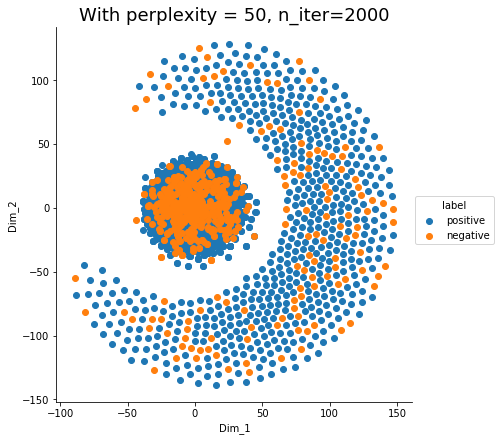

In [21]:
model = TSNE(n_components=2, random_state=0,perplexity=50, n_iter=2000)
# configuring the parameteres
# the number of components = 2
# default learning rate = 200
# Maximum number of iterations for the optimization = 2000

tsne_data = model.fit_transform(standarized_data)


# creating a3 new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50, n_iter=2000', size=18)
plt.show()

# With perplexity = 50 and iteration=3000

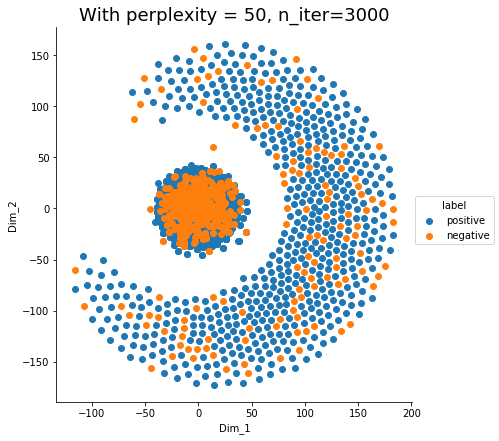

In [22]:
model = TSNE(n_components=2, random_state=0,perplexity=50, n_iter=3000)
# configuring the parameteres
# the number of components = 2
# default learning rate = 200
# Maximum number of iterations for the optimization = 3000

tsne_data = model.fit_transform(standarized_data)


# creating a3 new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50, n_iter=3000' ,size=18)
plt.show()

# With perplexity = 50 and iteration=5000

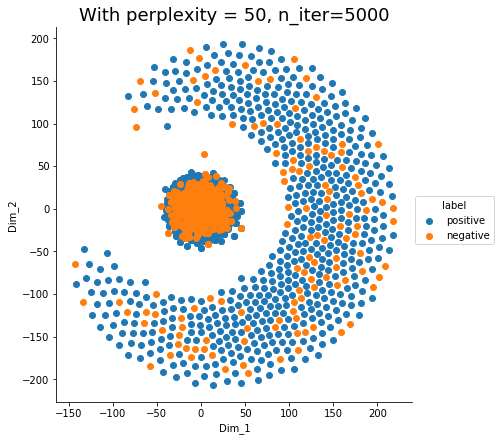

In [23]:
model = TSNE(n_components=2, random_state=0,perplexity=50, n_iter=5000)
# configuring the parameteres
# the number of components = 2
# perplexity = 50
# default learning rate = 200
# Maximum number of iterations for the optimization = 5000

tsne_data = model.fit_transform(standarized_data)


# creating a3 new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50, n_iter=5000', size=18)
plt.show()

# Bi gram

In [24]:
#in bigram we create a vector of two words at same time
count_vect = CountVectorizer(ngram_range=(1,2) ,min_df=5) #in scikit-learn
# min df for frequency of words, if repeat 5 times then it will be taken

final_bigram_counts = count_vect.fit_transform(final['CleanedText'].values) 
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4000, 6377)
the number of unique words including both unigrams and bigrams  6377


In [25]:
#changing sparse matrix to dense matix 
# because as we know bow gives sparse matrix 
#and for apllying tsne we need dense matrix 
final_bigram_counts=final_bigram_counts.toarray()
sc = StandardScaler()
standarized_data=sc.fit_transform(final_bigram_counts)
import warnings
warnings.filterwarnings("ignore")

# Tsne on bigram

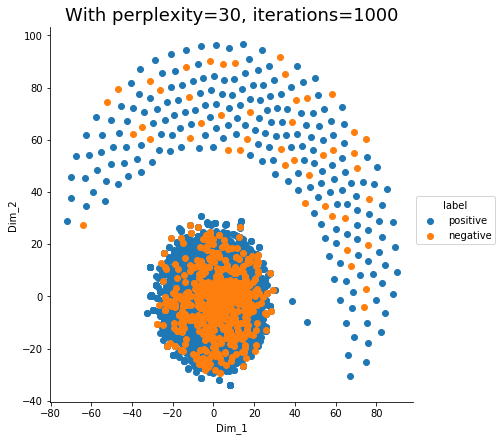

In [26]:
model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(standarized_data)


# creating a3 new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity=30, iterations=1000',size=18)
plt.show()

# TF-IDF

In [27]:
# here we fit the model for tfidf and also min df=5 
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=5)
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4000, 6377)
the number of unique words including both unigrams and bigrams  6377


In [28]:
# again changing sparse matrix to dense matrix to aplly tsne 
# because for tsne we can not process with sparse matrix
final_tf_idf=final_tf_idf.toarray()
sc = StandardScaler()
standarized_data=sc.fit_transform(final_tf_idf)
import warnings
warnings.filterwarnings("ignore")


# t sne on tf idf

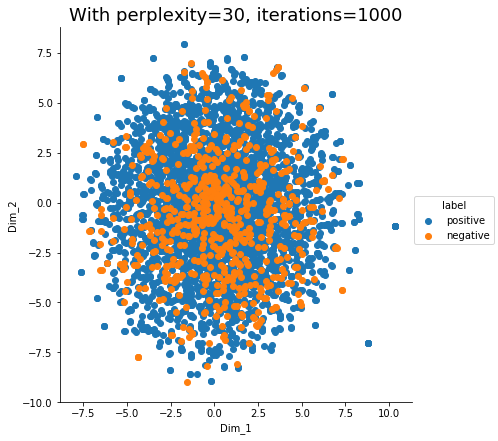

In [29]:
model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(standarized_data)


# creating a3 new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity=30, iterations=1000',size=18)
plt.show()

#  Word2Vec

In [30]:
# finding w2v to apply tsne 
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [31]:
#created the model with the help of list_of_sent 
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [32]:
w2v_words = list(w2v_model.wv.vocab) #passing the list of words 
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50]) # showing for understanding 

number of words that occured minimum 5 times  3264
sample words  ['littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'hes', 'learn', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'grew', 'read', 'sendak', 'watch', 'realli', 'movi', 'howev', 'miss', 'hard', 'cover', 'version', 'seem', 'kind', 'flimsi', 'take', 'two', 'hand', 'keep', 'page', 'open', 'fun', 'way', 'children', 'month', 'year']


# 3. AVG w2v

In [33]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors)) #for unnderstanding 
print(len(sent_vectors[0]))

4000
50


In [34]:
# standarized the data to aplly tsne
sc = StandardScaler() # creating object to fit and transform 
standarized_data=sc.fit_transform(sent_vectors)
import warnings
warnings.filterwarnings("ignore")

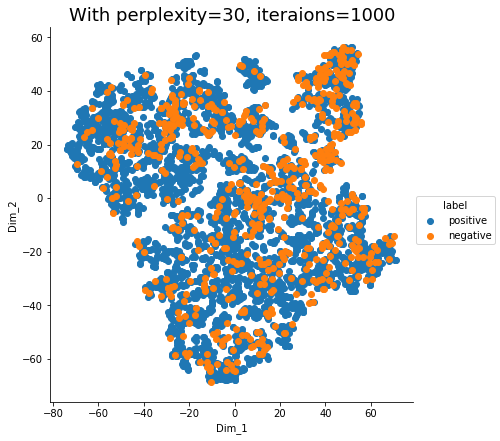

In [35]:
model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(standarized_data)


# creating a3 new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity=30, iteraions=1000',size=18)
plt.show()

# TFIDF W2V 

In [36]:
# finding tfif w2v to apply tsne 
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)

In [37]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [38]:
# standarizing the data to apply tsne
sc = StandardScaler()
standarized_data=sc.fit_transform(tfidf_sent_vectors)
import warnings
warnings.filterwarnings("ignore")

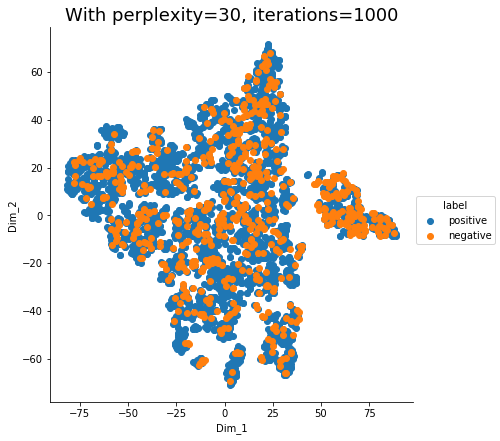

In [40]:
model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(standarized_data) #training the model with standarized data to apply tsne 


# creating a3 new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity=30, iterations=1000' ,size=18)
plt.show()

# Conclusions:-

1. In this assignment i have plotted tsne on amazon fine food reviews dataset which is real data 
2. Our goal is to represent the data in low dimension and to visualize clearly in low dimesnions  
3. For achieving our goal we have applied tsne on bag of words, bigram, tf-idf, avgw2v and tf-idfw2v 
4. first of all, let's start with the procedure of applying tsne on amazon fine food reviews.i read the data first then i clean data also deduplication of data, then i remove html tags, punctuation and special characters 
5. Then we find bag of words and we changed into dense matrix to apply tsne, and we plot the tsne with diffrent perplexity and iterations to know the variations in visualizing the data from high dimensions to low dimensions like two dimensions. and where we saw there is no more variaions in visualization of data then we stop  the changes in perplexity and iterations.
6. But as we can see in our visualization with tsne we are not able to separate the positive reviews and negative reviews 
7. And bag of words make sparse matrix which we can not use to plot tsne of sparse matrix so convert the sparse matrix into dense matrix then we transform our data into standarized data 
8. After converting the data into standarized data we plot tsne on standarized data 
9. If we apply standarized data to plot tsne then first time we have default perplexity eqaul to 30 and number of iterations equal to 1000 then we change the perplexity and iterations again and again to check whether the variation exist or not. and if we see there is no variation in visualization of data to separate positive reviews and negative reviews then we stop changing the value of perplexity and number of iterations.
10. So we did this procedure of changing the perplexity and number of iterations on bag of words to visualize the reviews
11. After apllying tsne on bag of words with diffrent value of perplexity and number of iterations we aplly tsne on rest of the data such as tf-idf, w2v, avgw2v and tf-idfw2v.  
12. Finally we can say, we have plotted tsne to change the high dimension in low dimension to clear visualize the data and also classifying the data beacuase in high dimension data we can not visualize the high dimension data.so we used tsne to visualize the high dimension data. 